In [2]:
import os
import sys
import math
import numpy as np
import netCDF4 as nc
from matplotlib import pyplot as plt
from math import exp, sqrt, log
import time
import geopandas as gpd
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
if '..' not in sys.path:
    sys.path.append('..')
from importlib import reload
#reload(util_tools)
import util_tools
from util_tools.data_loader import data_processer

C:\Users\96349\anaconda3\envs\Downscale_env\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\96349\anaconda3\envs\Downscale_env\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\96349\anaconda3\envs\Downscale_env\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\96349\anaconda3\env

# 1. Data Processing

In [3]:
# define necessary parameters
target_var = 'DUEXTTAU'
file_path_g_06 = r'C:\Users\96349\Documents\Downscale_data\MERRA2\G5NR_aerosol_variables_over_MiddleEast_daily_20060516-20070515.nc'
file_path_g_05 = r'C:\Users\96349\Documents\Downscale_data\MERRA2\G5NR_aerosol_variables_over_MiddleEast_daily_20050516-20060515.nc'
file_path_m = r'C:\Users\96349\Documents\Downscale_data\MERRA2\MERRA2_aerosol_variables_over_MiddleEast_daily_20000516-20180515.nc'
file_path_ele = r'C:\Users\96349\Documents\Downscale_data\elevation\elevation_data.npy'
file_path_country = [r'C:\Users\96349\Documents\Downscale_data\Country_shape\AFG_adm/AFG_adm0.shp',
                     r'C:\Users\96349\Documents\Downscale_data\Country_shape\ARE_adm/ARE_adm0.shp',
                     r'C:\Users\96349\Documents\Downscale_data\Country_shape\IRQ_adm/IRQ_adm0.shp',
                     r'C:\Users\96349\Documents\Downscale_data\Country_shape\KWT_adm/KWT_adm0.shp',
                     r'C:\Users\96349\Documents\Downscale_data\Country_shape\QAT_adm/QAT_adm0.shp',
                     r'C:\Users\96349\Documents\Downscale_data\Country_shape\SAU_adm/SAU_adm0.shp']
n_lag = 10
n_pred = 3
task_dim = [5, 5]

In [4]:
reload(util_tools.data_loader)
import util_tools.data_loader as data_loader

In [5]:
data_processor = data_loader.data_processer()
g_data, m_data, [G_lats, G_lons, M_lats, M_lons], ele_data = data_processor.load_data(target_var, file_path_g_05, file_path_g_06, file_path_m, file_path_ele, file_path_country)

In [19]:
g_data.max()

1.0138762841804878

(array([[ 7.,  7.,  5., ...,  5., 12.,  8.],
        [ 6.,  9.,  4., ...,  5., 12.,  9.],
        [ 8.,  7.,  4., ...,  5., 12.,  9.],
        ...,
        [ 0.,  4., 10., ..., 10.,  0.,  0.],
        [ 0.,  4., 11., ..., 10.,  0.,  0.],
        [ 0.,  4., 11., ..., 10.,  0.,  0.]]),
 array([0.97885198, 0.98201847, 0.98518495, 0.98835144, 0.99151793,
        0.99468441, 0.9978509 , 1.00101738, 1.00418387, 1.00735036,
        1.01051684]),
 <a list of 207 BarContainer objects>)

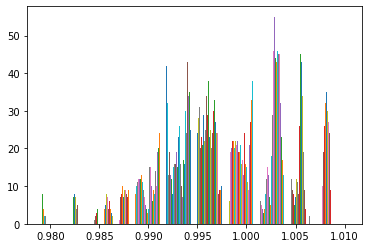

In [16]:
plt.hist(np.array(g_data[-5]))

In [8]:
g_data.max()

1.0138762841804878

In [22]:
m_data = data_processor.unify_m_data(g_data[:10], m_data, G_lats, G_lons, M_lats, M_lons)

In [23]:
match_m_data = m_data[range(1826, 1826+730), :, :]

In [24]:
match_m_data.shape == (730, 123, 207)

True

In [25]:
X_high, X_low, X_ele, X_other, Y = data_processor.flatten(g_data[:20, :10, :10], match_m_data[:20, :10, :10], ele_data[:10, :10],
                                                          [G_lats[:10], G_lons[:10]], list(range(20)), n_lag=n_lag, n_pred=n_pred, task_dim=task_dim, is_perm=True, 
                                                          return_Y=True)

In [16]:
np.concatenate([X_high, X_high], axis=0).shape

(576, 10, 5, 5, 1)

In [146]:
def reconstruct(pred_Y, org_dim, task_dim):
    rec_Y = dict()
    lat_dim = org_dim[0]+1 - pred_Y.shape[-2]
    lon_dim = org_dim[1]+1 -pred_Y.shape[-1]
    for i, lat_corner in enumerate(range(pred_Y.shape[-2], org_dim[0]+1), 1):
        for j, lon_corner in enumerate(range(pred_Y.shape[-1], org_dim[1]+1), 1):
            current_index = (i-1)*lon_dim + j-1
            current_mtx = pred_Y[current_index]
            for k, lat in enumerate(range(lat_corner-task_dim[0], lat_corner)):
                for h, lon in enumerate(range(lon_corner-task_dim[1], lon_corner)):
                    if (lat, lon) not in rec_Y:
                        rec_Y.setdefault((lat, lon), [current_mtx[k, h]])
                    else:
                        rec_Y[(lat, lon)].append(current_mtx[k, h])
    out = np.zeros(org_dim)
    for a in range(org_dim[0]):
        for b in range(org_dim[1]):
            out[a, b] = np.mean(rec_Y[(a, b)])
    return out

In [147]:
recon_Y = reconstruct(Y[:, 0, :, :], [10, 10], task_dim)

In [155]:
pred_list = [recon_Y, recon_Y, recon_Y]
np.expand_dims(np.array(pred_list), 1).shape

(3, 1, 10, 10)

In [179]:
temp_matrix = np.zeros((3,3,10, 10))
pred_list = [recon_Y,  recon_Y, recon_Y]
temp_matrix = np.concatenate([temp_matrix[1:], np.expand_dims(np.array(pred_list), 0)], axis=0)

In [12]:
import time 
time.time()

1663883632.2123516

# 2. GAN model test

In [33]:
def nnelu(input):
    return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(input))

def mapping_to_target_range( x, target_min=0, target_max=1 ) :
    x02 = tf.keras.backend.tanh(x) + 1 # x in range(0,2)
    scale = ( target_max-target_min )/2.
    return  x02 * scale + target_min


high_input = tf.keras.Input(shape=(n_lag, task_dim[0], task_dim[1], 1))
x1 = tf.keras.layers.ConvLSTM2D(16, kernel_size=(3,3), return_sequences=True, activation=tf.keras.layers.LeakyReLU())(high_input)
x1 = tf.keras.layers.ConvLSTM2D(16, kernel_size=(3,3), activation=tf.keras.layers.LeakyReLU())(x1)
x1 = tf.keras.layers.Flatten()(x1)

low_input = tf.keras.Input(shape=(n_lag, task_dim[0], task_dim[1], 1))
x2 = tf.keras.layers.ConvLSTM2D(16, kernel_size=(3,3), activation=tf.keras.layers.LeakyReLU())(low_input)
x2 = tf.keras.layers.Flatten()(x1)

ele_input = tf.keras.Input(shape=(task_dim[0], task_dim[1], 1))
x3 = tf.keras.layers.Conv2D(16, kernel_size=(3,3), activation=tf.keras.layers.LeakyReLU())(ele_input)
x3 = tf.keras.layers.Flatten()(x3)

other_input =  tf.keras.Input(shape=(3))
x4 = tf.keras.layers.Dense(8, activation=tf.keras.layers.LeakyReLU())(other_input)

x = tf.keras.layers.Concatenate(axis=1)([x1, x2, x3, x4])
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(30, activation=tf.keras.layers.LeakyReLU())(x)
x = tf.keras.layers.Dense(n_pred*np.prod(task_dim), activation=nnelu)(x)
x = tf.keras.layers.Reshape([n_pred, task_dim[0], task_dim[1]])(x)
generator = tf.keras.Model([high_input, low_input, ele_input, other_input], x)
generator.compile(optimizer='adam', loss='mean_absolute_error')

In [34]:
# define callbacks
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
best_save = tf.keras.callbacks.ModelCheckpoint('s2s_model', save_best_only=True, monitor='val_loss', mode='min')
callbacks = [lr_scheduler, early_stopping, best_save]

history = generator.fit([X_high, X_low, X_ele, X_other], Y, epochs=100, callbacks=callbacks, validation_split=0.25)

Epoch 1/100
6/7 [========================>.....] - ETA: 0s - loss: 0.4447

INFO:tensorflow:Assets written to: s2s_model\assets


INFO:tensorflow:Assets written to: s2s_model\assets


7/7 [==============================] - 19s 2s/step - loss: 0.4364 - val_loss: 0.2596 - lr: 0.0010
Epoch 2/100
6/7 [========================>.....] - ETA: 0s - loss: 0.3345

INFO:tensorflow:Assets written to: s2s_model\assets


INFO:tensorflow:Assets written to: s2s_model\assets


7/7 [==============================] - 12s 2s/step - loss: 0.3309 - val_loss: 0.1734 - lr: 0.0010
Epoch 3/100
6/7 [========================>.....] - ETA: 0s - loss: 0.2471

INFO:tensorflow:Assets written to: s2s_model\assets


INFO:tensorflow:Assets written to: s2s_model\assets


7/7 [==============================] - 12s 2s/step - loss: 0.2432 - val_loss: 0.1325 - lr: 0.0010
Epoch 4/100
6/7 [========================>.....] - ETA: 0s - loss: 0.2001

INFO:tensorflow:Assets written to: s2s_model\assets


INFO:tensorflow:Assets written to: s2s_model\assets


7/7 [==============================] - 13s 2s/step - loss: 0.1993 - val_loss: 0.1010 - lr: 0.0010
Epoch 5/100
5/7 [====================>.........] - ETA: 0s - loss: 0.1683

INFO:tensorflow:Assets written to: s2s_model\assets


INFO:tensorflow:Assets written to: s2s_model\assets


7/7 [==============================] - 16s 3s/step - loss: 0.1644 - val_loss: 0.0819 - lr: 0.0010
Epoch 6/100
7/7 [==============================] - ETA: 0s - loss: 0.1336

INFO:tensorflow:Assets written to: s2s_model\assets


INFO:tensorflow:Assets written to: s2s_model\assets


7/7 [==============================] - 14s 2s/step - loss: 0.1336 - val_loss: 0.0706 - lr: 0.0010
Epoch 7/100
6/7 [========================>.....] - ETA: 0s - loss: 0.1138

INFO:tensorflow:Assets written to: s2s_model\assets


INFO:tensorflow:Assets written to: s2s_model\assets


7/7 [==============================] - 14s 2s/step - loss: 0.1124 - val_loss: 0.0645 - lr: 0.0010
Epoch 8/100
6/7 [========================>.....] - ETA: 0s - loss: 0.0993

INFO:tensorflow:Assets written to: s2s_model\assets


INFO:tensorflow:Assets written to: s2s_model\assets


7/7 [==============================] - 14s 2s/step - loss: 0.0979 - val_loss: 0.0576 - lr: 0.0010
Epoch 9/100
6/7 [========================>.....] - ETA: 0s - loss: 0.0896

INFO:tensorflow:Assets written to: s2s_model\assets


INFO:tensorflow:Assets written to: s2s_model\assets


7/7 [==============================] - 14s 2s/step - loss: 0.0895 - val_loss: 0.0513 - lr: 0.0010
Epoch 10/100
6/7 [========================>.....] - ETA: 0s - loss: 0.0791

INFO:tensorflow:Assets written to: s2s_model\assets


INFO:tensorflow:Assets written to: s2s_model\assets


7/7 [==============================] - 14s 2s/step - loss: 0.0788 - val_loss: 0.0470 - lr: 0.0010
Epoch 11/100
6/7 [========================>.....] - ETA: 0s - loss: 0.0718

INFO:tensorflow:Assets written to: s2s_model\assets


INFO:tensorflow:Assets written to: s2s_model\assets


7/7 [==============================] - 14s 2s/step - loss: 0.0712 - val_loss: 0.0418 - lr: 0.0010
Epoch 12/100
6/7 [========================>.....] - ETA: 0s - loss: 0.0616

INFO:tensorflow:Assets written to: s2s_model\assets


INFO:tensorflow:Assets written to: s2s_model\assets


7/7 [==============================] - 15s 2s/step - loss: 0.0617 - val_loss: 0.0400 - lr: 0.0010
Epoch 13/100
7/7 [==============================] - ETA: 0s - loss: 0.0566

INFO:tensorflow:Assets written to: s2s_model\assets


INFO:tensorflow:Assets written to: s2s_model\assets


7/7 [==============================] - 14s 2s/step - loss: 0.0566 - val_loss: 0.0378 - lr: 0.0010
Epoch 14/100
7/7 [==============================] - ETA: 0s - loss: 0.0514

INFO:tensorflow:Assets written to: s2s_model\assets


INFO:tensorflow:Assets written to: s2s_model\assets


7/7 [==============================] - 14s 2s/step - loss: 0.0514 - val_loss: 0.0336 - lr: 0.0010
Epoch 15/100
7/7 [==============================] - 0s 32ms/step - loss: 0.0470 - val_loss: 0.0343 - lr: 0.0010
Epoch 16/100
7/7 [==============================] - ETA: 0s - loss: 0.0421

INFO:tensorflow:Assets written to: s2s_model\assets


INFO:tensorflow:Assets written to: s2s_model\assets


7/7 [==============================] - 15s 3s/step - loss: 0.0421 - val_loss: 0.0321 - lr: 0.0010
Epoch 17/100
5/7 [====================>.........] - ETA: 0s - loss: 0.0399

INFO:tensorflow:Assets written to: s2s_model\assets


INFO:tensorflow:Assets written to: s2s_model\assets


7/7 [==============================] - 14s 2s/step - loss: 0.0400 - val_loss: 0.0310 - lr: 0.0010
Epoch 18/100
6/7 [========================>.....] - ETA: 0s - loss: 0.0383

INFO:tensorflow:Assets written to: s2s_model\assets


INFO:tensorflow:Assets written to: s2s_model\assets


7/7 [==============================] - 14s 2s/step - loss: 0.0381 - val_loss: 0.0300 - lr: 0.0010
Epoch 19/100
7/7 [==============================] - ETA: 0s - loss: 0.0348

INFO:tensorflow:Assets written to: s2s_model\assets


INFO:tensorflow:Assets written to: s2s_model\assets


7/7 [==============================] - 13s 2s/step - loss: 0.0348 - val_loss: 0.0292 - lr: 0.0010
Epoch 20/100
6/7 [========================>.....] - ETA: 0s - loss: 0.0332

KeyboardInterrupt: 

In [20]:
g2_model = tf.keras.models.load_model('s2s_model')

In [27]:
pd.DataFrame(history.history).to_csv('history.csv')

In [26]:
pred_Y = g2_model.predict([X_high[-1:], X_low[-1:], X_ele[-1:], X_other[-1:]])

In [28]:
pred_Y.mean()

0.9427106

In [112]:
np.sqrt(np.mean(np.square(pred_Y[-1] - Y[-1])))

0.010288388300887755

In [100]:
from util_tools.data_processing import rsquared
rsquared(pred_Y[0, 0].reshape((25)), Y[0,0].reshape((25)))

(0.008515162367835552, 0.6608753429840621)

In [117]:
pred_input = tf.keras.Input(shape=(n_pred, task_dim[0], task_dim[1]))
y1 = tf.keras.layers.Flatten()(pred_input)
'''
condition_input = tf.keras.Input(shape=(3))
y2 = tf.keras.layers.Dense(8, activation='relu')(condition_input)
y = tf.keras.layers.Concatenate(axis=1)([y1, y2])
'''
y = tf.keras.layers.Dense(8, activation=tf.keras.layers.LeakyReLU())(y1)
y = tf.keras.layers.Dropout(0.8)(y)
y = tf.keras.layers.Dense(1, activation='sigmoid')(y)
discriminator = tf.keras.Model([pred_input], y)
discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [118]:
reload(util_tools.cGAN_model)
from util_tools.cGAN_model import  Condition_GAN

In [122]:
cGAN = Condition_GAN(generator, discriminator)
cGAN.fit(5, 30, [X_high, X_low, X_ele, X_other], Y)

Epoch:1, batch:1/6, real_loss=0.634, fake_loss=0.769, g_loss=0.692
Epoch:1, batch:2/6, real_loss=0.586, fake_loss=0.953, g_loss=0.705
Epoch:1, batch:3/6, real_loss=0.691, fake_loss=0.595, g_loss=0.688
Epoch:1, batch:4/6, real_loss=0.383, fake_loss=0.807, g_loss=0.591
Epoch:1, batch:5/6, real_loss=0.594, fake_loss=0.430, g_loss=0.600
Epoch:1, batch:6/6, real_loss=0.358, fake_loss=0.644, g_loss=0.589
Epoch:2, batch:1/6, real_loss=0.527, fake_loss=0.627, g_loss=0.709
Epoch:2, batch:2/6, real_loss=0.447, fake_loss=0.860, g_loss=0.680
Epoch:2, batch:3/6, real_loss=0.383, fake_loss=0.463, g_loss=0.615
Epoch:2, batch:4/6, real_loss=0.484, fake_loss=0.496, g_loss=0.686
Epoch:2, batch:5/6, real_loss=0.562, fake_loss=0.471, g_loss=0.647
Epoch:2, batch:6/6, real_loss=0.605, fake_loss=0.767, g_loss=0.621
Epoch:3, batch:1/6, real_loss=0.603, fake_loss=0.329, g_loss=0.619
Epoch:3, batch:2/6, real_loss=0.694, fake_loss=0.643, g_loss=0.605
Epoch:3, batch:3/6, real_loss=0.424, fake_loss=0.661, g_loss=0

In [123]:
generator.predict([X_high[:3], X_low[:3], X_ele[:3], X_other[:3]])

array([[[[0.8665214 , 1.2154813 , 0.5742026 , 1.1931497 , 0.71439743],
         [0.9954182 , 0.3683976 , 0.8625089 , 1.425251  , 0.50635064],
         [0.5054725 , 0.9580225 , 1.0433807 , 0.6285501 , 1.0431772 ],
         [0.7981943 , 1.5731097 , 0.9249619 , 0.8616722 , 0.59727335],
         [0.5140573 , 0.95949286, 0.6270662 , 1.241638  , 0.75372356]],

        [[1.5097042 , 1.2523549 , 0.48150563, 1.2555624 , 0.7489146 ],
         [1.6177773 , 0.7694826 , 0.40843403, 0.9733394 , 0.8524309 ],
         [1.186528  , 1.5459706 , 1.0745908 , 1.2855966 , 1.4296491 ],
         [0.7716894 , 0.9346115 , 0.77756846, 1.240102  , 0.8940858 ],
         [0.54506534, 1.1562147 , 1.3063023 , 1.5097346 , 0.72588825]]],


       [[[0.86630523, 1.2159221 , 0.5721369 , 1.1952002 , 0.71524763],
         [0.9942844 , 0.36784196, 0.8628505 , 1.4258636 , 0.50646466],
         [0.5058225 , 0.9570836 , 1.043303  , 0.62991464, 1.0408068 ],
         [0.7978578 , 1.5721087 , 0.92737603, 0.8630987 , 0.59764117],


In [25]:
X = [X_high, X_low, X_ele, X_other]
j =0
batch_size=2
batch_X = [d[j*batch_size:(j+1)*batch_size] for d in X]

In [28]:
batch_X[0].shape

(2, 4, 5, 5, 1)

In [30]:
np.zeros((batch_size, 1), dtype='int')

array([[0],
       [0]])

# 3. downscaler test

In [215]:
reload(downscale)
from util_tools import downscale

In [216]:
dscler = downscale.downscaler(generator)

In [217]:
h_data = g_data[10:10+n_lag]
l_data = m_data[1836: 1856]
days = list(range(1836, 1856))

In [219]:
downscaled_data = dscler.downscale(h_data, l_data, ele_data,  [G_lats, G_lons, M_lats, M_lons], days, n_lag, n_pred, task_dim)

In [220]:
downscaled_data.shape

(16, 123, 207)

In [221]:
h_data.shape

(4, 123, 207)